<a href="https://colab.research.google.com/github/NavyaPatil10/deep/blob/main/TextOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
robikscube_textocr_text_extraction_from_images_dataset_path = kagglehub.dataset_download('robikscube/textocr-text-extraction-from-images-dataset')

print('Data source import complete.')

Data source import complete.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
!pip install torch torchvision torchaudio -q
!pip install datasets transformers Pillow matplotlib numpy scikit-learn -q
!pip install Levenshtein # For Character Error Rate (CER)
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.4 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from PIL import Image
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import json
from collections import Counter

In [6]:

dataset_path = "/kaggle/input/textocr-text-extraction-from-images-dataset"
image_folder = os.path.join(dataset_path, "train_val_images/train_images/")
ann_path = os.path.join(dataset_path, "annot.csv")
img_path = os.path.join(dataset_path, "img.csv")

try:
    df_ann = pd.read_csv(ann_path).dropna(subset=['utf8_string'])
    df_img = pd.read_csv(img_path)


    df_ann = df_ann.sort_values(by=['image_id', 'id'])
    image_to_text = df_ann.groupby('image_id')['utf8_string'].apply(lambda x: ' '.join(x)).reset_index()


    df_merged = pd.merge(image_to_text, df_img, left_on='image_id', right_on='id')
    print(f"Number of images after merging with text: {len(df_merged)}")
    print(df_merged.head())

except FileNotFoundError:
    print(f"Error: Annotation or image info file not found at the specified path.")
    print("Please check the variables 'ann_path', 'img_path', and 'image_folder'.")
    exit()

except Exception as e:
    print(f"Error while reading or processing data:{e}")
    exit()


# --- Vocabulary Creation ---
all_texts = df_merged['utf8_string'].tolist()
char_counter = Counter()
for text in all_texts:
    char_counter.update(text)


min_freq = 5
vocab = [char for char, count in char_counter.items() if count >= min_freq]


PAD_TOKEN = '<PAD>'
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'
UNK_TOKEN = '<UNK>'
special_tokens = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]
vocab = special_tokens + sorted(list(vocab))

char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = {idx: char for idx, char in enumerate(vocab)}
vocab_size = len(vocab)

PAD_IDX = char2idx[PAD_TOKEN]
SOS_IDX = char2idx[SOS_TOKEN]
EOS_IDX = char2idx[EOS_TOKEN]
UNK_IDX = char2idx[UNK_TOKEN]

print(f" Vocabulary size: {vocab_size}")
# print(f"Vocabulary: {''.join(vocab)}")

Number of images after merging with text: 21778
           image_id                                        utf8_string  \
0  0000e8b36676338b                             FELIX PRIVAT DBU 889 .   
1  00010bf498b64bab  TEQU . . . . . . . . . . A . tel . . . . . . ....   
2  00016982f6086d39  3G UpCode Zip Tfl Tfl Map WinRaR Options Back ...   
3  0001c6bf48e16ab2        NISSAN GENISS . NISSAN LIVINA GENISS NISSAN   
4  000209d575f3aa4f  . . . . . . . . . . 6 BEER. . . . BEER MACAU M...   

   Unnamed: 0                id  width  height    set  \
0       15677  0000e8b36676338b   1024     685  train   
1       13865  00010bf498b64bab   1024     576  train   
2        7978  00016982f6086d39    576    1024  train   
3       10601  0001c6bf48e16ab2   1024     966  train   
4       12476  000209d575f3aa4f    682    1024  train   

                    file_name  
0  train/0000e8b36676338b.jpg  
1  train/00010bf498b64bab.jpg  
2  train/00016982f6086d39.jpg  
3  train/0001c6bf48e16ab2.jpg  
4  t

In [7]:
# --- Dataset Class ---
class TextOCRDataset(Dataset):
    def __init__(self, df, image_folder, char2idx, transform=None, max_seq_len=100):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform
        self.char2idx = char2idx
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = row['file_name'].replace("train/", "")
        img_path = os.path.join(self.image_folder, img_filename)
        text = row['utf8_string']

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except FileNotFoundError:
            print(f"Warning: Image not found at {img_path}. Skipping.")

            return self.__getitem__(0)
        except Exception as e:
            print(f"Warning: Error loading image {img_path}: {e}. Skipping.")
            return self.__getitem__(0)


        # Tokenize text
        text_indices = [self.char2idx.get(char, UNK_IDX) for char in text]


        seq = [SOS_IDX] + text_indices[:self.max_seq_len-2] + [EOS_IDX]
        padding_len = self.max_seq_len - len(seq)
        padded_seq = seq + [PAD_IDX] * padding_len

        target_tensor = torch.tensor(padded_seq, dtype=torch.long)

        return image, target_tensor

# --- Transforms and DataLoader ---

IMG_HEIGHT = 64
IMG_WIDTH = 256
MAX_SEQ_LEN = 150


transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_size = int(0.8 * len(df_merged))
val_size = int(0.1 * len(df_merged))
test_size = len(df_merged) - train_size - val_size


df_shuffled = df_merged.sample(frac=1, random_state=42).reset_index(drop=True)

df_train = df_shuffled[:train_size]
df_val = df_shuffled[train_size:train_size + val_size]
df_test = df_shuffled[train_size + val_size:]


train_dataset = TextOCRDataset(df_train, image_folder, char2idx, transform, max_seq_len=MAX_SEQ_LEN)
val_dataset = TextOCRDataset(df_val, image_folder, char2idx, transform, max_seq_len=MAX_SEQ_LEN)
test_dataset = TextOCRDataset(df_test, image_folder, char2idx, transform, max_seq_len=MAX_SEQ_LEN)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


try:
    img_batch, tgt_batch = next(iter(train_loader))
    print("Image batch shape:", img_batch.shape) # Should be [BATCH_SIZE, 3, IMG_HEIGHT, IMG_WIDTH]
    print("Target batch shape:", tgt_batch.shape) # Should be [BATCH_SIZE, MAX_SEQ_LEN]
except Exception as e:
    print(f"Error while retrieving the first batch from train_loader: {e}")
    print("Please check the image paths and the dataset creation process.")


Train samples: 17422, Val samples: 2177, Test samples: 2179
Train batches: 545, Val batches: 69, Test batches: 69
Image batch shape: torch.Size([32, 3, 64, 256])
Target batch shape: torch.Size([32, 150])


In [8]:
# --- Model Components ---

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: [max_len, 1, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class ImageEncoder(nn.Module):

    def __init__(self, d_model, backbone_name='resnet34', pretrained=True):
        super().__init__()
        if backbone_name == 'resnet34':
            backbone = models.resnet34(pretrained=pretrained)
            self.features = nn.Sequential(*list(backbone.children())[:-2])
            cnn_out_channels = 512

            self.feature_proj = nn.Conv2d(cnn_out_channels, d_model, kernel_size=1)

        elif backbone_name == 'simple_cnn':

            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2), # 64x32x128
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2), # 128x16x64
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)), # 256x8x64
                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)), # 512x4x64
                nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0), nn.ReLU() # 512x3x63 (ví dụ)
            )
            cnn_out_channels = 512
            self.feature_proj = nn.Conv2d(cnn_out_channels, d_model, kernel_size=1)
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")

        self.d_model = d_model

    def forward(self, x):

        features = self.features(x)
        features = self.feature_proj(features)


        bs, d, h, w = features.shape
        features = features.view(bs, d, h * w)
        features = features.permute(2, 0, 1)
        return features

class TextDecoder(nn.Module):

    def __init__(self, vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=False)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def generate_square_subsequent_mask(self, sz):

        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask # Shape: [sz, sz]

    def forward(self, tgt, memory, tgt_mask=None, tgt_padding_mask=None):

        # Embedding và Positional Encoding cho target sequence
        tgt = self.embedding(tgt) * math.sqrt(self.d_model) # Shape: [tgt_len, batch_size, d_model]
        tgt = self.pos_encoder(tgt)


        if tgt_mask is None:
            device = tgt.device
            tgt_mask = self.generate_square_subsequent_mask(len(tgt)).to(device) # Shape [tgt_len, tgt_len]

        # Transformer Decoder
        output = self.transformer_decoder(tgt, memory,
                                          tgt_mask=tgt_mask,
                                          memory_key_padding_mask=None,
                                          tgt_key_padding_mask=tgt_padding_mask) # Shape: [tgt_len, batch_size, d_model]


        output = self.fc_out(output) # Shape: [tgt_len, batch_size, vocab_size]
        return output


class ImageToTextOCR(nn.Module):

    def __init__(self, vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward,
                 cnn_backbone='simple_cnn', dropout=0.1):
        super().__init__()
        self.encoder = ImageEncoder(d_model, backbone_name=cnn_backbone)
        self.decoder = TextDecoder(vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward, dropout)
        self.d_model = d_model

    def forward(self, src_img, tgt_seq, tgt_padding_mask):

        memory = self.encoder(src_img) # Shape: [src_len, batch_size, d_model]

        tgt_len = tgt_seq.size(0)
        device = tgt_seq.device
        tgt_mask = self.decoder.generate_square_subsequent_mask(tgt_len).to(device) # [tgt_len, tgt_len]

        output = self.decoder(tgt_seq, memory, tgt_mask=tgt_mask, tgt_padding_mask=tgt_padding_mask)
        # output shape: [tgt_len, batch_size, vocab_size]
        return output

    def encode(self, src_img):

        return self.encoder(src_img)

    def decode(self, tgt_seq, memory, tgt_mask):

        return self.decoder(tgt_seq, memory, tgt_mask=tgt_mask)

In [9]:
# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model Hyperparameters
D_MODEL = 128      # Embedding dimension
NHEAD = 4       # Number of attention heads
NUM_DECODER_LAYERS = 2 # Number of decoder layers
DIM_FEEDFORWARD = 512 # Hidden dimension in FFN
DROPOUT = 0.1
CNN_BACKBONE = 'simple_cnn' # or 'resnet34'

model = ImageToTextOCR(vocab_size, D_MODEL, NHEAD, NUM_DECODER_LAYERS, DIM_FEEDFORWARD,
                       cnn_backbone=CNN_BACKBONE, dropout=DROPOUT).to(device)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
# model.apply(initialize_weights)

# Optimizer and Loss
LEARNING_RATE = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# --- Training Loop ---
NUM_EPOCHS = 10
CLIP = 1.0 # Gradient Clipping

def train_one_epoch(model, loader, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0
    pbar = tqdm(loader, desc="Training", leave=False)

    for images, targets in pbar:
        images = images.to(device)
        targets = targets.to(device) # Shape: [batch_size, seq_len]


        target_input = targets[:, :-1] # Shape: [batch_size, seq_len-1]
        target_output = targets[:, 1:] # Shape: [batch_size, seq_len-1]



        target_padding_mask = (target_input == PAD_IDX) # Shape: [batch_size, seq_len-1]


        # target_input: [seq_len-1, batch_size]
        target_input = target_input.permute(1, 0)

        optimizer.zero_grad()

        # Forward pass
        # output shape: [seq_len-1, batch_size, vocab_size]
        output = model(images, target_input, target_padding_mask)


        # output: [ (seq_len-1) * batch_size, vocab_size ]
        # target_output: [ (seq_len-1) * batch_size ]
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        target_output = target_output.reshape(-1)

        loss = criterion(output, target_output)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    return epoch_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    pbar = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for images, targets in pbar:
            images = images.to(device)
            targets = targets.to(device)

            target_input = targets[:, :-1]
            target_output = targets[:, 1:]
            target_padding_mask = (target_input == PAD_IDX)
            target_input = target_input.permute(1, 0)

            output = model(images, target_input, target_padding_mask)

            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            target_output = target_output.reshape(-1)

            loss = criterion(output, target_output)
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

    return epoch_loss / len(loader)

# --- Start Training ---
best_val_loss = float('inf')

print("Starting Training...")
for epoch in range(1, NUM_EPOCHS + 1):
    print(f"--- Epoch {epoch}/{NUM_EPOCHS} ---")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, CLIP, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_ocr_model.pt')
        print(f"\t >> Saved Best Model (Val Loss: {best_val_loss:.4f})")

    print(f"\t Training Loss: {train_loss:.4f}")
    print(f"\t Validation Loss: {val_loss:.4f}")

print("Training Finished.")

model.load_state_dict(torch.load('best_ocr_model.pt',
                                 map_location=device))

Using device: cuda
Starting Training...
--- Epoch 1/10 ---


Training:   0%|          | 0/545 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

	 >> Saved Best Model (Val Loss: 3.5697)
	 Training Loss: 3.7763
	 Validation Loss: 3.5697
--- Epoch 2/10 ---


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

	 >> Saved Best Model (Val Loss: 3.5619)
	 Training Loss: 3.5632
	 Validation Loss: 3.5619
--- Epoch 3/10 ---


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

	 >> Saved Best Model (Val Loss: 3.5614)
	 Training Loss: 3.5600
	 Validation Loss: 3.5614
--- Epoch 4/10 ---


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

	 >> Saved Best Model (Val Loss: 3.5612)
	 Training Loss: 3.5582
	 Validation Loss: 3.5612
--- Epoch 5/10 ---


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

	 Training Loss: 3.5573
	 Validation Loss: 3.5618
--- Epoch 6/10 ---


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

	 >> Saved Best Model (Val Loss: 3.5600)
	 Training Loss: 3.5577
	 Validation Loss: 3.5600
--- Epoch 7/10 ---


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

	 Training Loss: 3.5564
	 Validation Loss: 3.5603
--- Epoch 8/10 ---


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

	 Training Loss: 3.5565
	 Validation Loss: 3.5611
--- Epoch 9/10 ---


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

	 Training Loss: 3.5567
	 Validation Loss: 3.5601
--- Epoch 10/10 ---


Training:   0%|          | 0/545 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

	 Training Loss: 3.5561
	 Validation Loss: 3.5606
Training Finished.


<All keys matched successfully>

In [10]:
# --- Inference Function ---
def predict_text(model, image_tensor, max_len, sos_idx, eos_idx, device):

    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        memory = model.encode(image_tensor) # Shape: [src_len, 1, d_model]


        tgt_indices = [sos_idx]

        for i in range(max_len - 1):
            tgt_tensor = torch.LongTensor(tgt_indices).unsqueeze(1).to(device) # Shape [current_len, 1]


            tgt_mask = model.decoder.generate_square_subsequent_mask(tgt_tensor.size(0)).to(device)


            tgt_emb = model.decoder.embedding(tgt_tensor) * math.sqrt(model.d_model)
            tgt_emb = model.decoder.pos_encoder(tgt_emb)
            output = model.decoder.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask)

            output_logits = model.decoder.fc_out(output[-1, :, :])


            pred_token_idx = output_logits.argmax(1).item()
            tgt_indices.append(pred_token_idx)


            if pred_token_idx == eos_idx:
                break


    tokens = [idx2char.get(idx, UNK_TOKEN) for idx in tgt_indices[1:-1]]
    return "".join(tokens)

# --- Evaluation Metrics ---

try:
    import jiwer
except ImportError:

    print("Please install the 'jiwer' library: pip install jiwer")

    jiwer = None

def calculate_metrics(model, loader, device):
    model.eval()
    all_preds = []
    all_gts = []
    pbar = tqdm(loader, desc="Testing", leave=False)

    for images, targets in pbar:

        for i in range(targets.size(0)):
            gt_indices = targets[i].tolist()

            gt_tokens = [idx2char[idx] for idx in gt_indices if idx not in (SOS_IDX, EOS_IDX, PAD_IDX)]
            all_gts.append("".join(gt_tokens))


            pred_text = predict_text(model, images[i], MAX_SEQ_LEN, SOS_IDX, EOS_IDX, device)
            all_preds.append(pred_text)

    if jiwer:
        wer = jiwer.wer(all_gts, all_preds)
        cer = jiwer.cer(all_gts, all_preds)

        exact_matches = sum(1 for gt, pred in zip(all_gts, all_preds) if gt == pred)
        em_ratio = exact_matches / len(all_gts)

        print(f"\n--- Test Set Evaluation ---")
        print(f"Word Error Rate (WER): {wer:.4f}")
        print(f"Character Error Rate (CER): {cer:.4f}")
        print(f"Exact Match Ratio: {em_ratio:.4f}")
        return wer, cer, em_ratio
    else:

        print("Jiwer is not installed. Unable to calculate WER/CER.")


        print("\n--- Sample Predictions ---")
        for i in range(min(5, len(all_gts))):
             print(f"GT : {all_gts[i]}")
             print(f"PRED: {all_preds[i]}\n")
        return None, None, None


test_wer, test_cer, test_em = calculate_metrics(model, test_loader, device)

Testing:   0%|          | 0/69 [00:00<?, ?it/s]


--- Test Set Evaluation ---
Word Error Rate (WER): 1.0000
Character Error Rate (CER): 1.0000
Exact Match Ratio: 0.0000


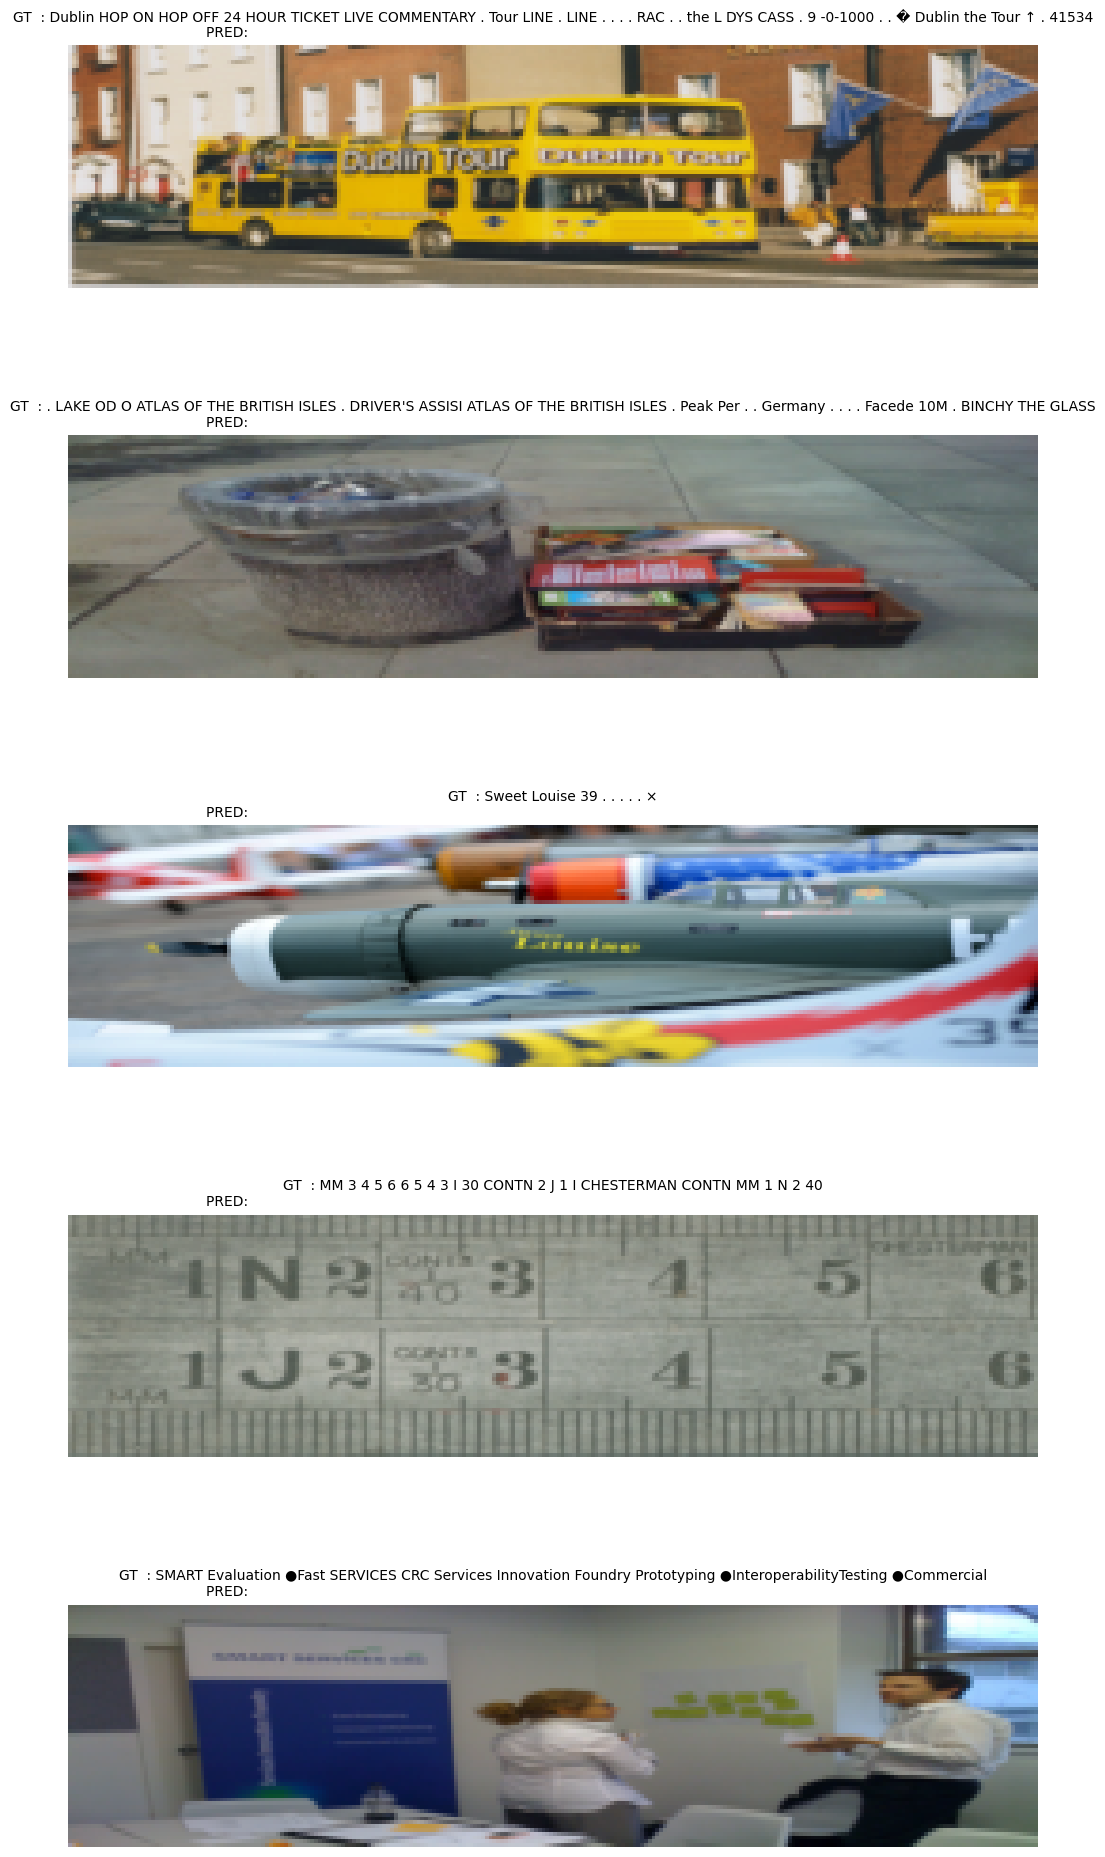

In [11]:
import random
import matplotlib.pyplot as plt

def visualize_prediction(model, dataset, idx2char, device, num_samples=5):

    model.eval()
    dataset_indices = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, num_samples * 4))
    if num_samples == 1:
        axes = [axes]

    for i, data_idx in enumerate(dataset_indices):
        image, target_tensor = dataset[data_idx]


        predicted_text = predict_text(model, image, MAX_SEQ_LEN, SOS_IDX, EOS_IDX, device)


        gt_indices = target_tensor.tolist()
        gt_text = "".join([idx2char[idx] for idx in gt_indices if idx not in (SOS_IDX, EOS_IDX, PAD_IDX)])


        img_display = image.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].axis('off')
        axes[i].set_title(f"GT  : {gt_text}\nPRED: {predicted_text}", fontsize=10)

    plt.tight_layout()
    plt.show()


visualize_prediction(model, test_dataset, idx2char, device, num_samples=5)



>> Number of images in JSON: 21778
>> Example annotation for image a4ea732cd3d5948a:
 {'id': 'a4ea732cd3d5948a', 'width': 840, 'height': 1024, 'set': 'train', 'file_name': 'train/a4ea732cd3d5948a.jpg'}

>> annot.csv:
   Unnamed: 0                  id          image_id  \
0           0  a4ea732cd3d5948a_1  a4ea732cd3d5948a   
1           1  a4ea732cd3d5948a_2  a4ea732cd3d5948a   
2           2  a4ea732cd3d5948a_3  a4ea732cd3d5948a   
3           3  a4ea732cd3d5948a_4  a4ea732cd3d5948a   
4           4  a4ea732cd3d5948a_5  a4ea732cd3d5948a   

                            bbox  utf8_string  \
0   [525.83, 3.4, 197.64, 33.94]  Performance   
1  [534.67, 64.68, 91.22, 38.19]        Sport   
2  [626.95, 63.62, 96.52, 31.82]        Watch   
3  [577.4, 141.87, 147.13, 43.1]   ...period.   
4  [391.03, 163.9, 60.82, 38.65]            .   

                                              points     area  
0  [525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525...  6707.90  
1  [535.73, 64.68, 623.41, 67

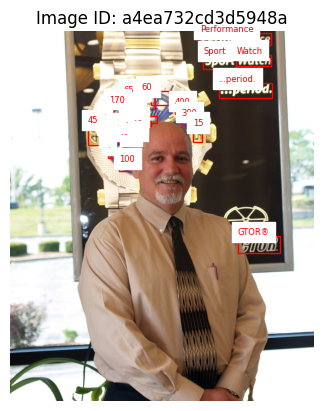

In [13]:
import os
import json
import pandas as pd
import pyarrow.parquet as pq
from PIL import Image
import matplotlib.pyplot as plt


dataset_path = "/kaggle/input/textocr-text-extraction-from-images-dataset"
image_folder = os.path.join(dataset_path, "train_val_images/train_images/")


json_path = os.path.join(dataset_path, "TextOCR_0.1_train.json")
with open(json_path, "r", encoding="utf-8") as f:
    data_json = json.load(f)

print(">> Number of images in JSON:", len(data_json["imgs"]))

sample_id = list(data_json["imgs"].keys())[0]
sample_ann = data_json["imgs"][sample_id]
print(f">> Example annotation for image {sample_id}:\n", sample_ann)



csv_ann = pd.read_csv(os.path.join(dataset_path, "annot.csv"))
csv_img = pd.read_csv(os.path.join(dataset_path, "img.csv"))
parquet_ann = pd.read_parquet(os.path.join(dataset_path, "annot.parquet"))
parquet_img = pd.read_parquet(os.path.join(dataset_path, "img.parquet"))

print("\n>> annot.csv:")
print(csv_ann.head())
print("\n>> img.csv:")
print(csv_img.head())


def check_missing(df, name):
    print(f"\n> Checking for missing data in {name}")

    missing = df.isnull().sum()
    print(missing[missing > 0])
    print(">> Number of rows with missing data:", df.isnull().any(axis=1).sum())


check_missing(csv_ann, "annot.csv")
check_missing(csv_img, "img.csv")


clean_ann = csv_ann.dropna()
clean_img = csv_img.dropna()
print("\n>> annot.csv after cleaning:", clean_ann.shape)
print(">> img.csv after cleaning:", clean_img.shape)



def display_image_with_annotation(image_id):
    row = clean_img[clean_img['id'] == image_id]
    if row.empty:
        print(f"Image with id {image_id} not found")

        return
    img_file = row['file_name'].values[0].replace("train/", "")
    img_path = os.path.join(image_folder, img_file)

    if not os.path.exists(img_path):
        print(f"Image {img_path} does not exist.")

        return

    image = Image.open(img_path).convert("RGB")
    anns = clean_ann[clean_ann["image_id"] == image_id]

    plt.imshow(image)
    plt.axis("off")
    for i, row in anns.iterrows():
        text = row['utf8_string']
        bbox = eval(row['bbox']) if isinstance(row['bbox'], str) else row['bbox']
        x, y, w, h = bbox
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=1))
        plt.text(x, y-5, text, fontsize=6, color='red', backgroundcolor='white')
    plt.title(f"Image ID: {image_id}")
    plt.show()


sample_image_id = clean_img['id'].iloc[0]
display_image_with_annotation(sample_image_id)